In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import time
import uuid

import matplotlib.pyplot as plt
import networkx as nx

from req_analysis import Requirement, Model

## Initialize connection to Neptune

In [3]:
%run 'req_analysis/neptune-util.py'
%env NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
%env NEPTUNE_CLUSTER_PORT=8182
g = neptune.graphTraversal()

env: NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
env: NEPTUNE_CLUSTER_PORT=8182
gremlin: ws://100.65.51.106:8182/gremlin


In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON, POST

sparql = SPARQLWrapper("http://100.65.51.106:3001/sparql")

In [5]:
query_requirements = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

# `Class` that has an `appliedStereotypeInstance` `InstanceSpecification` whose type is <<Requirement>> Stereotype (ID)
select * from mms-graph:data.tmt {
    # `Class` that has an `appliedStereotypeInstance`...
    ?class a uml-class:Class ;
        mms-property:appliedStereotypeInstance ?instance ;
        .

    # `InstanceSpecification`. Stereotype classifier and all slots
    ?instance mms-property:slot ?slot ;
        .

    # Slot --> value
    ?slot mms-property:valueValueSpecificationFromSlot ?slotValue ;
        .

    # value --> string
    ?slotValue a uml-class:LiteralString ;
        mms-property:valueString ?valueString ;
        .

    # filter string by those starting with html
    filter(regex(?valueString, \"^\\\\s*<\"))
}
"""

In [6]:
query_elements = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

select * from mms-graph:data.tmt {
    ?element a/rdfs:subClassOf* uml-class:Class
    {
        ?element rdfs:label ?label 
    } union {
        ?element mms-property:name ?label
    }
    
    filter(isLiteral(?label) && ?label != "")
}
"""

In [7]:
model = Model("http://100.65.51.106:3001/sparql")

## Clear output graph

In [8]:
clear = model.clear_graph("<https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test>")
clear.response.read()

b'[\n{\n    "type" : "UpdateEvent",\n    "totalElapsedMillis" : 0,\n    "elapsedMillis" : 0,\n    "connFlush" : 0,\n    "batchResolve" : 0,\n    "whereClause" : 0,\n    "deleteClause" : 0,\n    "insertClause" : 0\n},\n{\n    "type" : "Commit",\n    "totalElapsedMillis" : 0\n}\n]'

## Load model elements in memory

In [9]:
model_elements = model.get_model_elements(query_elements)

print(len(model_elements), 'model elements found')

2611 model elements found


## Load text element(s) of interest

In [10]:
single_req = model.get_requirement_by_id('slotValue', '_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring')

In [11]:
single_req

[{'slotValue': {'type': 'uri',
   'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring'},
  'slot': {'type': 'uri',
   'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311'},
  'valueString': {'type': 'literal',
   'value': '<html><body>\n<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety syst

In [12]:
text_elements = model.get_text_elements(query_requirements)

print(len(text_elements), 'text elements found')

6249 text elements found


## Matching

gremlin: ws://100.65.51.106:8182/gremlin
Req ID:  https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi 
Req text: <html><body>
<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests and possibly a defined subset of additi

KeyboardInterrupt: 

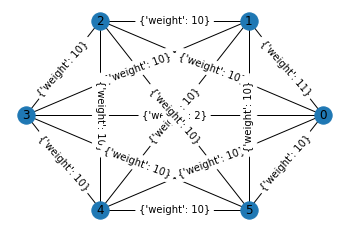

In [27]:
g = neptune.graphTraversal()
single_result = model.match_requirement(g, single_req[0], model_elements, pprint=True)

In [9]:
time2 = time.time()
g = neptune.graphTraversal()
req_object.init_match_subgraph(g)
print('Total time:', time.time()-time2)

gremlin: ws://100.65.51.106:8182/gremlin


NameError: name 'req_object' is not defined

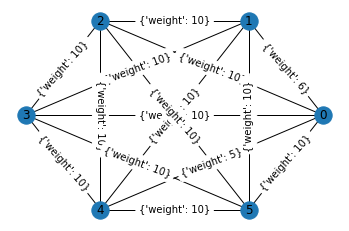

In [53]:
pos = nx.circular_layout(req_object.req_subgraph)
nx.draw_networkx_edge_labels(req_object.req_subgraph, pos)
nx.draw_circular(req_object.req_subgraph, with_labels=True)

In [55]:
winners = req_object.match_clustering()

for winner in winners.values():
    print('Token: ', winner['token']['text'])
    print('Element: ', winner['model_element']['name'])
    print('URI: ', winner['model_element']['uri'], '\n_________')

Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472 
_________
Token:  network
Element:  Network
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008 
_________
Token:  Executive Software
Element:  Executive Software
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
_________
Token:  networking
Element:  Networking
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749 
_________


In [57]:
g = neptune.graphTraversal()
req_object.allocation_discovery(g)

gremlin: ws://100.65.51.106:8182/gremlin


{117: {'token': {'text': 'the Data Management System',
   'pos': 'PROPN',
   'token_id': 117},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472',
   'name': 'Data Management System'},
  'score': 0.0013642900507215298},
 141: {'token': {'text': 'network', 'pos': 'PROPN', 'token_id': 141},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
   'name': 'Network'},
  'score': 1.5543122344752193e-17},
 124: {'token': {'text': 'Executive Software',
   'pos': 'PROPN',
   'token_id': 124},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
   'name': 'Executive Software'},
  'score': -0.0},
 144: {'token': {'text': 'networking', 'pos': 'NOUN', 'token_id': 144},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749',
   '

In [20]:
insert_blocks = """
<{input_uri}> mms-autocref:reference mms-autocref-i:Reference.{reference_uuid} ;
  .

mms-autocref-i:Reference.{reference_uuid}
  a mms-autocref:Reference ;
  mms-autocref:inputText \"\"\"{input_text}\"\"\" ;
  mms-autocref:match <{match_uri}> ;
  mms-autocref:token mms-autocref-i:Token.{reference_uuid} ;
  .

mms-autocref-i:Token.{reference_uuid}
  a mms-autocref:Token ;
  mms-autocref:tokenStart "{token_position}"^^xsd:integer ;
  mms-autocref:tokenText \"\"\"{token_text}\"\"\" ;
  .
"""

In [21]:
insert_query = """
prefix mms-autocref: <https://opencae.jpl.nasa.gov/mms/rdf/autocref/>
prefix mms-autocref-i: <https://opencae.jpl.nasa.gov/mms/rdf/autocref-instance/>

insert data {{
  graph <https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test> {{
    {insert_blocks}
  }}
}}"""

In [22]:
insert_concat = ""

for winner in winners.values():
    insert_concat += insert_blocks.format(input_uri = req_object.text_uri,
                                  input_text = req_object.text.replace('"', r'\"'),
                                  reference_uuid = uuid.uuid4().hex,
                                  match_uri = winner['model_element']['uri'],
                                  token_position = winner['token']['token_id'],
                                  token_text = winner['token']['text'].replace('"', r'\"'))

# print(insert_concat)
insert = insert_query.format(insert_blocks=insert_concat)
print(insert)


prefix mms-autocref: <https://opencae.jpl.nasa.gov/mms/rdf/autocref/>
prefix mms-autocref-i: <https://opencae.jpl.nasa.gov/mms/rdf/autocref-instance/>

insert data {
  graph <https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test> {
    
<https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi> mms-autocref:reference mms-autocref-i:Reference.6b33ed3eb50f44a48cdaffade37fe2d1 ;
  .

mms-autocref-i:Reference.6b33ed3eb50f44a48cdaffade37fe2d1
  a mms-autocref:Reference ;
  mms-autocref:inputText """<html><body>
<span xmlns=\"http://www.w3.org/1999/xhtml\"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as a

In [23]:
sparql.setMethod(POST)
sparql.setQuery(insert)


results = sparql.query()
print(results.response.read())

b'[\n{\n    "type" : "UpdateEvent",\n    "totalElapsedMillis" : 0,\n    "elapsedMillis" : 0,\n    "connFlush" : 0,\n    "batchResolve" : 0,\n    "whereClause" : 0,\n    "deleteClause" : 0,\n    "insertClause" : 0\n},\n{\n    "type" : "Commit",\n    "totalElapsedMillis" : 9\n}\n]'


In [24]:
from req_analysis.libs.neptune_wrapper import *

In [ ]:
g = neptune.graphTraversal()
named_class_elements = get_named_classes(g)
contexts = {source_node: get_type_from_part_properties(g, source_node) for source_node in named_class_elements}

In [36]:
len(contexts)

2518

In [39]:
time1 = time.time()
g = neptune.graphTraversal()
contexts2 = {source_node: get_type_from_part_properties(g, source_node) for source_node in named_class_elements[0:10]}
print(time1-time.time())

gremlin: ws://100.65.51.106:8182/gremlin
-1.500241994857788


## Single Req

In [19]:
time1 = time.time()
for result in single_req:
#     if str.startswith(result["str"]["value"], "<html>"):
    req_object = Requirement(result["instance"]["value"], result["valueString"]["value"])
    matches, c = req_object.match_req_tokens(model_elements, 0.0035)
    if len(matches)>2:
        print('Req ID: ', result["instance"]["value"], '\nReq text:' , (result["valueString"]["value"]))
        print(matches, '\n___________')
        print(c, 'comparaisons')
        print('Time: ', time.time()-time1)
        break

Req ID:  https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi 
Req text: <html><body>
<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests and possibly a defined subset of additional signals from all connected subsystem

In [24]:
time2 = time.time()
g = neptune.graphTraversal()
req_object.init_match_subgraph(g)
print('Total time:', time.time()-time2)

gremlin: ws://100.65.51.106:8182/gremlin
0 1
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b', 'name': 'Data Management System'}
FAILURE in  2.4492812156677246 s:  
_________
0 2
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472', 'name': 'Data Management System'}
Timeout

SUCCESS in  3.00030517578125 s  10
_________
0 3
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999', 'name': 'Executive Software'}

SUCCESS in  0.2521629333496094 s  2
_________
0 

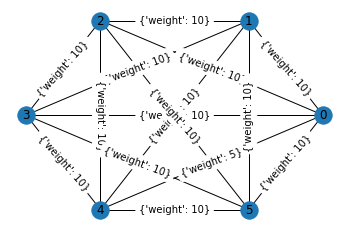

In [16]:
pos = nx.circular_layout(req_object.req_subgraph)
nx.draw_networkx_edge_labels(req_object.req_subgraph, pos)
nx.draw_circular(req_object.req_subgraph, with_labels=True)

In [17]:
req_object.req_subgraph.nodes(data=True)

NodeDataView({0: {'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}, 1: {'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}, 2: {'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}, 3: {'token': {'text': 'Executive Software', 'pos': 'PROPN', 'token_id': 124}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542

In [25]:
winners = req_object.match_clustering()

for winner in winners.values():
    print('Token: ', winner['token']['text'])
    print('Element: ', winner['model_element']['name'])
    print('URI: ', winner['model_element']['uri'], '\n_________')

Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095 
_________
Token:  Executive Software
Element:  Executive Software
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
_________
Token:  network
Element:  Network
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008 
_________
Token:  networking
Element:  Networking
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749 
_________


In [29]:
winners

{117: {'token': {'text': 'the Data Management System',
   'pos': 'PROPN',
   'token_id': 117},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472',
   'name': 'Data Management System'},
  'score': 0.0013642900507215298},
 141: {'token': {'text': 'network', 'pos': 'PROPN', 'token_id': 141},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
   'name': 'Network'},
  'score': 1.5543122344752193e-17},
 124: {'token': {'text': 'Executive Software',
   'pos': 'PROPN',
   'token_id': 124},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
   'name': 'Executive Software'},
  'score': -0.0},
 144: {'token': {'text': 'networking', 'pos': 'NOUN', 'token_id': 144},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749',
   '

In [26]:
g = neptune.graphTraversal()
req_object.allocation_discovery(g)

gremlin: ws://100.65.51.106:8182/gremlin


{117: {'token': {'text': 'the Data Management System',
   'pos': 'PROPN',
   'token_id': 117},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095',
   'name': 'Data Management System'},
  'score': 0.0013642900507215298},
 124: {'token': {'text': 'Executive Software',
   'pos': 'PROPN',
   'token_id': 124},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
   'name': 'Executive Software'},
  'score': -0.0},
 141: {'token': {'text': 'network', 'pos': 'PROPN', 'token_id': 141},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
   'name': 'Network'},
  'score': 1.5543122344752193e-17},
 144: {'token': {'text': 'networking', 'pos': 'NOUN', 'token_id': 144},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749',
   'n

# MISCELLANEOUS 

In [42]:
summit='_4663af6e-6265-438d-87b8-74e1550518bf__65_6314a138-53b9-42a5-b488-9c23967ed889'
enclosure='_18_0_6_f1d0357_1490143302007_461579_179266'
mirror='_18_5_2_e64033a_1509475358071_810923_58742'
aps_user='_17_0_2_3_41e01aa_1389730769202_855584_72742'
aps_mission='_17_0_2_3_41e01aa_1389728637481_651557_61606'
usr_part_aps_mission='_17_0_2_3_41e01aa_1389731842407_88153_73842'
value_aps_mission='_18_0_2_baa02e2_1421376436201_767368_80540'

In [71]:
g = neptune.graphTraversal()
path = g.V(aps_user).repeat(both().not_(hasId('master')).simplePath()).until(hasId(aps_mission).or_().loops().is_(5)).path().limit(1).toList()[0]

gremlin: ws://100.65.51.106:8182/gremlin


In [72]:
path

path[v[_17_0_2_3_41e01aa_1389730769202_855584_72742], v[_17_0_2_3_41e01aa_1389731842407_88153_73842], v[_17_0_2_3_41e01aa_1389728637481_651557_61606]]

In [73]:
from req_analysis.libs.neptune_wrapper import node_distance

In [96]:
def node_distance_n2(n, g, el_1, el_2):
        try:
            with time_limit(3):
                path = g.withSideEffect("Neptune#repeatMode", "DFS").V(el_1).repeat(both().not_(hasId('master')).simplePath()).until(hasId(el_2)).path().limit(1).toList()[0]
                print('print', path)
                if (path[0].id == el_1) and (path[-1].id == el_2):
                    return len(path)-1
                else:
                    return None
        except TimeoutException as e:
            print("Timeout")
            return None

In [97]:
g = neptune.graphTraversal()
node_distance_n2(3, g, aps_user, aps_mission)

gremlin: ws://100.65.51.106:8182/gremlin


GremlinServerError: 500: {"requestId":"998ca81f-6feb-4185-938b-61845a4b1e35","code":"InternalFailureException","detailedMessage":"Exception processing a script on request [RequestMessage{, requestId=998ca81f-6feb-4185-938b-61845a4b1e35, op='bytecode', processor='traversal', args={gremlin=[[withSideEffect(Neptune#repeatMode, DFS)], [V(_17_0_2_3_41e01aa_1389730769202_855584_72742), repeat([[], [both(), not([[], [hasId(master)]]), simplePath()]]), times(2), until([[], [hasId(_17_0_2_3_41e01aa_1389728637481_651557_61606)]]), path(), limit(1)]], aliases={g=g}}}]."}

In [76]:
g = neptune.graphTraversal()
node_distance(g, aps_user, aps_mission)

gremlin: ws://100.65.51.106:8182/gremlin
1 None
2 None
3 None
4 None
5 None
6 None
7 None
8 None


10

In [107]:
g = neptune.graphTraversal()
g.V('_18_0_2_b4c02e1_1443121772933_102673_179684').repeat(both().simplePath()).until(hasId('_18_0_2_b4c02e1_1443121772933_102673_179684_asi').or_().loops().is_(8)).path().limit(1).toList()

gremlin: ws://100.65.51.106:8182/gremlin


[path[v[_18_0_2_b4c02e1_1443121772933_102673_179684], v[_18_0_2_b4c02e1_1443121772933_102673_179684_asi]]]

In [108]:
g.V('_17_0_2_3_41e01aa_1389728637481_651557_61606').out('ownedAttributeFromClass').out().hasLabel('Class').valueMap().toList()

[{'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Operational Blackbox Specification JPL']},
 {'_label': ['M1 Control System']},
 {'_label': ['APS User']},
 {'_label': ['Executive Software']},
 {'_label': ['Common Services']},
 {'_label': ['Telescope Control System']}]

In [31]:
len(g.V().hasLabel('Class').has('_label').toList())

2518

In [ ]:
_17_0_2_3_41e01aa_1389728637481_651557_61606,_18_0_2_baa02e2_1421376436201_767368_80540

In [29]:
g = neptune.graphTraversal()
g.V('_17_0_2_3_41e01aa_1383543404575_236284_66843').repeat(both().simplePath()).until(hasId('_17_0_2_3_41e01aa_1383543404576_569689_66846').or_().loops().is_(8)).path().limit(1).toList()

gremlin: ws://100.65.51.106:8182/gremlin


[path[v[_17_0_2_3_41e01aa_1383543404575_236284_66843], v[_17_0_2_3_41e01aa_1383543404576_569689_66846]]]

In [51]:
g.V(aps_mission).repeat(out('ownerElement')).emit().as_('x').repeat(__.in_('ownerElement')).emit(hasId(usr_part_aps_mission)).select('x').limit(1).toList()

[v[_18_0_2_baa02e2_1421374196576_95730_78327]]

In [25]:
g.V(usr_part_aps_mission).out('ownerElement').limit(1).toList()

[v[_17_0_2_3_41e01aa_1389728637481_651557_61606]]

In [49]:
g.V(aps_mission).both().toList()

[v[_17_0_2_3_41e01aa_1389728637481_651557_61606_asi],
 v[_17_0_2_3_41e01aa_1389728637481_651557_61606_asi],
 v[_18_0_2_baa02e2_1421374196576_95730_78327],
 v[_17_0_2_3_41e01aa_1389729306878_38075_62969],
 v[_17_0_2_3_41e01aa_1389729306878_38075_62969],
 v[_17_0_2_3_41e01aa_1389731842407_88153_73842],
 v[_17_0_2_3_41e01aa_1389731842407_88153_73842],
 v[_17_0_2_3_41e01aa_1392143906001_327948_74735],
 v[_17_0_2_3_41e01aa_1392143906001_327948_74735],
 v[_17_0_2_3_41e01aa_1392143851234_419249_74564],
 v[_17_0_2_3_41e01aa_1392143851234_419249_74564],
 v[_18_0_2_baa02e2_1421376436201_767368_80540],
 v[_18_0_2_baa02e2_1421376436201_767368_80540],
 v[_17_0_2_3_41e01aa_1392141049983_161762_73149],
 v[_17_0_2_3_41e01aa_1392141049983_161762_73149],
 v[_18_0_5_baa02e2_1450822437908_614610_154553],
 v[_18_0_5_baa02e2_1450822437908_614610_154553],
 v[_17_0_2_3_41e01aa_1389730627603_980584_72643],
 v[_17_0_2_3_41e01aa_1389730627603_980584_72643],
 v[_18_0_4_baa02e2_1438799229720_161594_151777],
 v[_18

In [ ]:
g = neptune.graphTraversal()
g.V(enclosure).valueMap().toList()

In [ ]:
import spacy

nlp_np = spacy.load("en_core_web_sm")
merge_nps = nlp_np.create_pipe("merge_noun_chunks")
nlp_np.add_pipe(merge_nps)


In [ ]:
for t in nlp_np("Hello my name is the beautiful car of New York. Bye!"):
    print(t.text, t.pos_, t.idx)

In [ ]:
def node_distance(neptune_instance, el_1, el_2):
    try:
        with time_limit(3):
            path = neptune_instance.V(el_1).repeat(both().not_(hasId('master')).simplePath()).until(hasId(el_2).or_().loops().is_(8)).path().limit(1).toList()[0]
            if (path[0].id == el_1) and (path[-1].id == el_2):
                return len(path)-1
            else:
                return 10
    except TimeoutException as e:
        print("Timeout")
        return 10
    
        

In [ ]:
g = neptune.graphTraversal()
node_distance(g, aps_user, summit)